# Goal: to predict max temp for NYC for a particular day.

In [68]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime, timedelta
import pickle
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Identifying Data sources

(1) NOAA

(2) Visual crossing

(3) Accuweather

(4) openweathermap

(5) WeatherUnderground

in my quest to find the ideal data set for the given problem statement I stumbled upon the above mentioned data sources, out of which I chose NOAA and visual crossing.
NOAA has accurate weather data for upto 150 years but not the last three days and visual crossing enables us to update the dataset. Both are free resources and have api access which makes handling of data that much easier.


## For historical data we download it from NOAA directly, no need for an api.

In [69]:
df = pd.read_csv('Data/centalpark_from2000.csv')

df.head()

,STATION,NAME,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,...,WT09,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT22
0,USW00094728,"NY CITY CENTRAL PARK, NY US",2000-01-01,5.82,0.0,0.0,0.0,42.0,50,34,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00094728,"NY CITY CENTRAL PARK, NY US",2000-01-02,4.70,0.0,0.0,0.0,52.0,60,43,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00094728,"NY CITY CENTRAL PARK, NY US",2000-01-03,6.71,0.0,0.0,0.0,58.0,64,51,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USW00094728,"NY CITY CENTRAL PARK, NY US",2000-01-04,7.83,0.7,0.0,0.0,53.0,60,46,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,USW00094728,"NY CITY CENTRAL PARK, NY US",2000-01-05,11.41,0.0,0.0,0.0,38.0,47,29,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


## Data pre processing

In [70]:
df = df[['DATE', 'TMAX', 'TMIN']]
df.head()

,DATE,TMAX,TMIN
0,2000-01-01,50,34
1,2000-01-02,60,43
2,2000-01-03,64,51
3,2000-01-04,60,46
4,2000-01-05,47,29


In [71]:
df.isnull().sum()

DATE    0
TMAX    0
TMIN    0
dtype: int64

In [72]:
# Historical TMAX features

df['TMAX_prev7'] = df['TMAX'].rolling(7, closed = 'left').max()
df['TMAX_prev3'] = df['TMAX'].rolling(3, closed = 'left').max()
df['TMAX_prev2'] = df['TMAX'].rolling(2, closed = 'left').max()

df['TMAX_prev1'] = df['TMAX'].rolling(1, closed = 'left').max()



In [73]:
# Historical TMIN features

# df['TMIN_prev7'] = df['TMIN'].rolling(7, closed = 'left').max()
df['TMIN_prev3'] = df['TMIN'].rolling(3, closed = 'left').max()
df['TMIN_prev2'] = df['TMIN'].rolling(2, closed = 'left').max()
df['TMIN_prev1'] = df['TMIN'].rolling(1, closed = 'left').max()


In [74]:
print(df.head())

         DATE  TMAX  TMIN  TMAX_prev7  TMAX_prev3  TMAX_prev2  TMAX_prev1  \
0  2000-01-01    50    34         NaN         NaN         NaN         NaN   
1  2000-01-02    60    43         NaN         NaN         NaN        50.0   
2  2000-01-03    64    51         NaN         NaN        60.0        60.0   
3  2000-01-04    60    46         NaN        64.0        64.0        64.0   
4  2000-01-05    47    29         NaN        64.0        64.0        60.0   

   TMIN_prev3  TMIN_prev2  TMIN_prev1  
0         NaN         NaN         NaN  
1         NaN         NaN        34.0  
2         NaN        43.0        43.0  
3        51.0        51.0        51.0  
4        51.0        51.0        46.0  


In [75]:
# Removing those buffer rows we used to computer the above features

df = df.loc[7:, :]
print(df.head())

          DATE  TMAX  TMIN  TMAX_prev7  TMAX_prev3  TMAX_prev2  TMAX_prev1  \
7   2000-01-08    38    30        64.0        49.0        49.0        49.0   
8   2000-01-09    51    37        64.0        49.0        49.0        38.0   
9   2000-01-10    58    44        64.0        51.0        51.0        51.0   
10  2000-01-11    52    40        60.0        58.0        58.0        58.0   
11  2000-01-12    47    39        58.0        58.0        58.0        52.0   

    TMIN_prev3  TMIN_prev2  TMIN_prev1  
7         35.0        35.0        35.0  
8         35.0        35.0        30.0  
9         37.0        37.0        37.0  
10        44.0        44.0        44.0  
11        44.0        44.0        40.0  


In [76]:
# Date to datetime format

df['DATE'] = pd.to_datetime(df['DATE'])

In [77]:
# Day and month features

df['day'] = df['DATE'].dt.day
df['month'] = df['DATE'].dt.month

In [78]:
df.sort_values(by = ['DATE'], inplace = True)

In [79]:
df.set_index("DATE", inplace = True)

In [80]:
df.fillna(-1, inplace = True)

In [81]:
# Removing the real time features , except TMAX since its label

df.drop([ 'TMIN',], axis = 1, inplace = True)


In [82]:
df.head()

,TMAX,TMAX_prev7,TMAX_prev3,TMAX_prev2,TMAX_prev1,TMIN_prev3,TMIN_prev2,TMIN_prev1,day,month
DATE,,,,,,,,,,
2000-01-08,38,64.0,49.0,49.0,49.0,35.0,35.0,35.0,8,1
2000-01-09,51,64.0,49.0,49.0,38.0,35.0,35.0,30.0,9,1
2000-01-10,58,64.0,51.0,51.0,51.0,37.0,37.0,37.0,10,1
2000-01-11,52,60.0,58.0,58.0,58.0,44.0,44.0,44.0,11,1
2000-01-12,47,58.0,58.0,58.0,52.0,44.0,44.0,40.0,12,1


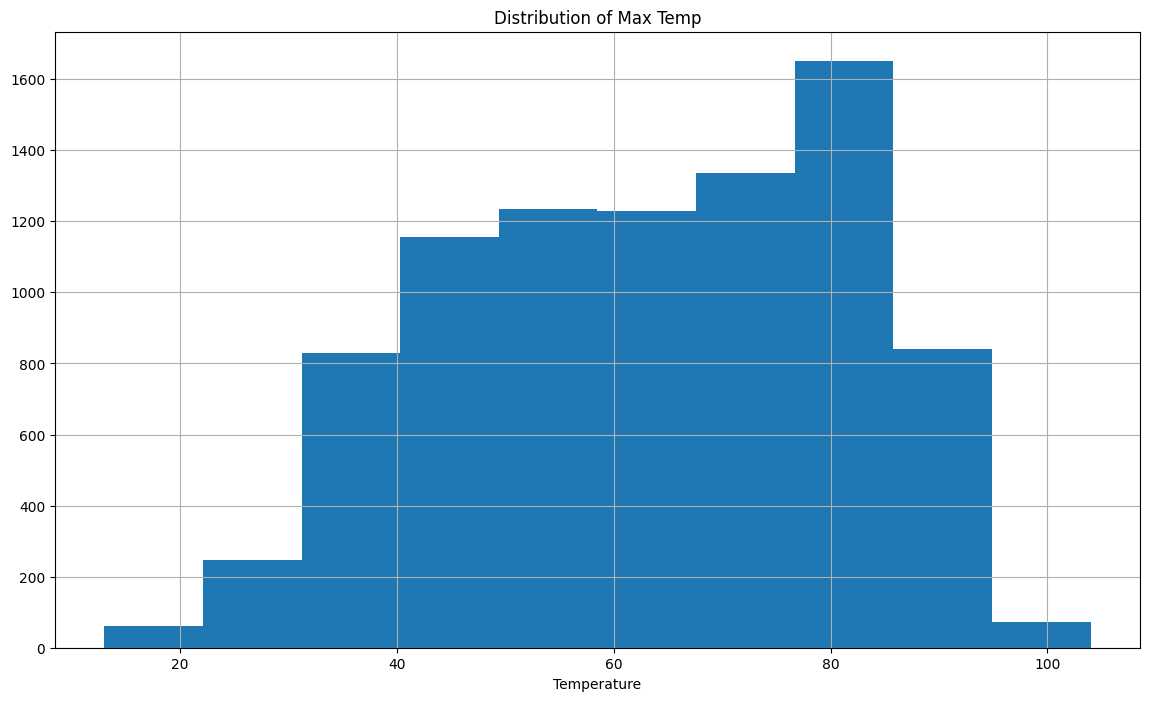

In [83]:
plt.rcParams['figure.figsize'] = [14, 8]
df.TMAX.hist()
plt.title('Distribution of Max Temp')
plt.xlabel('Temperature')
plt.show()

In [84]:
train_df, test_df = train_test_split(df)

In [85]:
X_train, X_test, y_train, y_test = train_df.drop(['TMAX'], axis = 1).values, test_df.drop(['TMAX'], axis = 1).values, train_df['TMAX'].values, test_df['TMAX'].values 


## XGBoost

In [86]:
model = XGBRegressor()
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [87]:
y_pred = model.predict(X_test)

In [88]:

print(f"MSE = {mean_squared_error(y_test, y_pred)}")

print(f"MAE = {mean_absolute_error(y_test, y_pred)}")

MSE = 48.80227055579888
MAE = 5.462419521781094


In [89]:
pred_df = pd.DataFrame()
pred_df.index = test_df.index
pred_df['true_label'] = y_test
pred_df['pred_label'] = y_pred



In [90]:
print(pred_df)

            true_label  pred_label
DATE                              
2012-03-07          62   45.961529
2005-10-23          54   54.675732
2003-01-17          30   35.204704
2009-09-16          70   76.855362
2020-03-05          51   52.934093
...                ...         ...
2015-12-18          57   60.236435
2012-10-05          78   71.669113
2007-07-25          83   80.716187
2017-05-23          69   65.461967
2013-02-03          30   35.246231

[2165 rows x 2 columns]


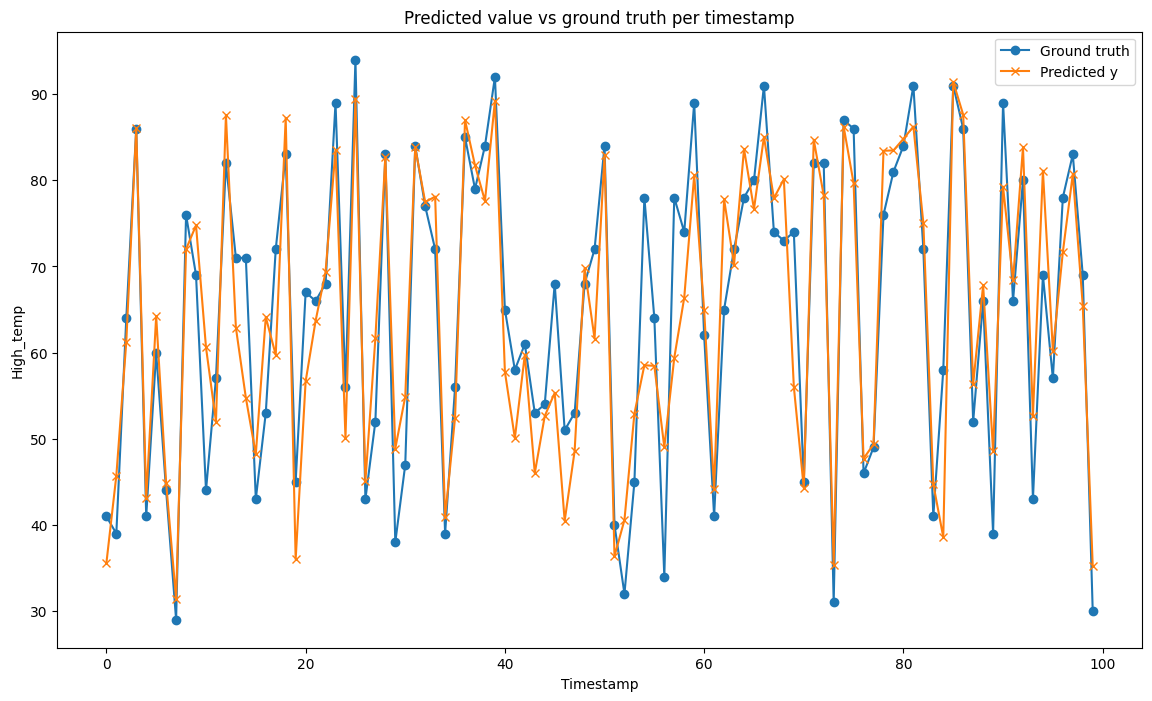

In [91]:
plt.plot(y_test[-100:], label='Ground truth', linestyle='-', marker='o')
plt.plot(y_pred[-100:], label='Predicted y', linestyle='-', marker='x')

plt.xlabel('Timestamp')
plt.ylabel('High_temp')
plt.title('Predicted value vs ground truth per timestamp')

plt.legend()
plt.show()

In [92]:

file_name = "models/xgb_reg.pkl"

# save
pickle.dump(model, open(file_name, "wb"))


## Linear regression

In [93]:
lin_reg = LinearRegression()

In [94]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [95]:
y_pred = lin_reg.predict(X_test)

In [96]:


print(f"MSE = {mean_squared_error(y_test, y_pred)}")
print(f"MAE = {mean_absolute_error(y_test, y_pred)}")

MSE = 46.741216529889336
MAE = 5.3602342107675955


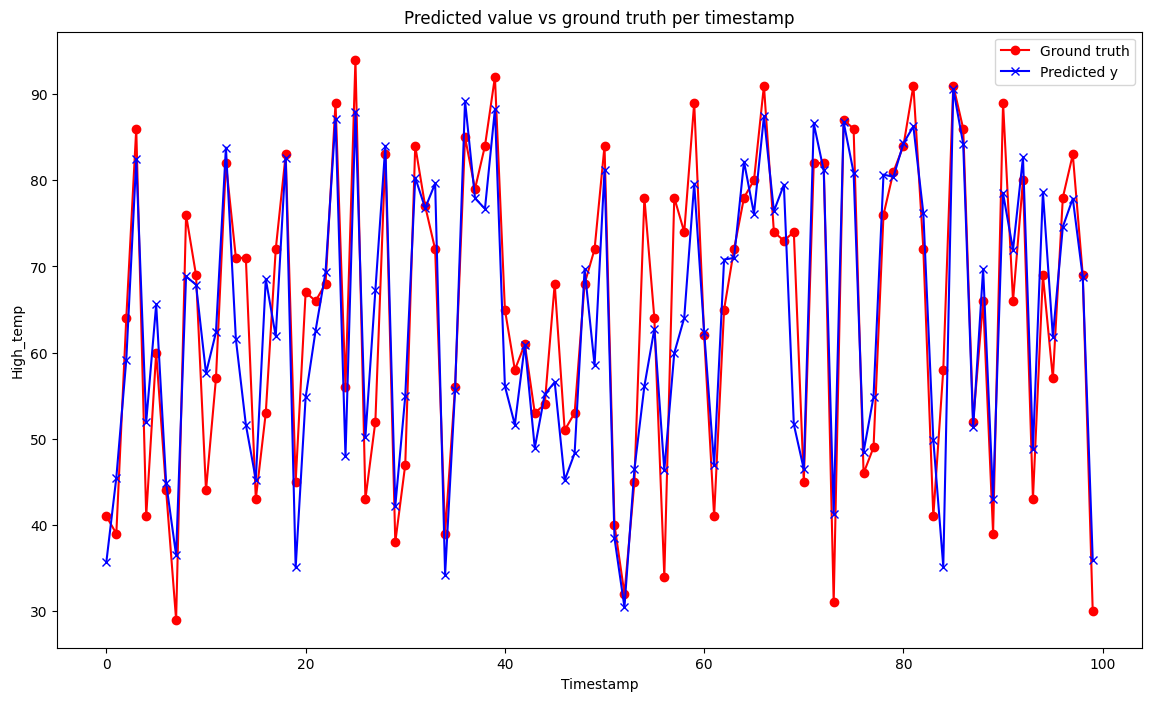

In [97]:
plt.plot(y_test[-100:], label='Ground truth', linestyle='-', marker='o', color = "red")
plt.plot(y_pred[-100:], label='Predicted y', linestyle='-', marker='x', color = "blue")

plt.xlabel('Timestamp')
plt.ylabel('High_temp')
plt.title('Predicted value vs ground truth per timestamp')

plt.legend()
plt.show()

In [98]:

file_name = "models/lin_reg.pkl"

# save
pickle.dump(model, open(file_name, "wb"))
